In [ ]:
import numpy as np
import pandas as pd 
import tensorflow as tf
import tensorflow_addons as tfa
from keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.layers import (Input, add, Dense, Activation, ZeroPadding2D,
                                     BatchNormalization, Flatten, Conv2D, AveragePooling2D,
                                     MaxPooling2D, GlobalMaxPooling2D,Dropout)
from keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

In [ ]:
FAST_RUN = False
IMAGE_WIDTH=224
IMAGE_HEIGHT=224
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3
INIT_LR = 1e-5
MAX_LR = 1e-2

In [ ]:
train_csv=pd.read_csv("../input/newmarking/marking_.csv")
filenames = []
categories = []
for row in train_csv.iterrows():
    filenames.append(row[1][0]+".jpg")
train = pd.DataFrame({
    'image_name': filenames,
    'target': train_csv['target']
})

In [ ]:
from sklearn.model_selection import train_test_split
train_daf, test_df  = train_test_split(train,test_size=0.2,
                                                    random_state=42,
                                                    stratify=train["target"])

In [ ]:
from sklearn.model_selection import train_test_split
train_df, validate_df  = train_test_split(train_daf,test_size=0.2,
                                                    random_state=42,
                                                    stratify=train_daf["target"])

<AxesSubplot:title={'center':'benign and maignent counter'}, xlabel='0:benign or 1:malignent'>

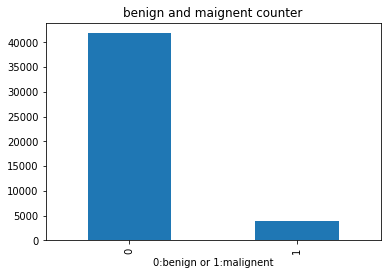

In [ ]:
train_daf['target'].value_counts().plot(title="benign and maignent counter",xlabel = "0:benign or 1:malignent", kind = "bar")

In [ ]:
total_img = train_daf["target"].size

malignant = np.count_nonzero(train_daf["target"])
benign = total_img - malignant
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total_img, malignant, 100 * malignant / total_img))

weight_for_0 = (1 / benign)*(total_img)/2.0 
weight_for_1 = (1 / malignant)*(total_img)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Examples:
    Total: 45779
    Positive: 3938 (8.60% of total)

Weight for class 0: 0.55
Weight for class 1: 5.81


In [ ]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=32

In [ ]:
train_datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,
                                   zoom_range=0.3,vertical_flip=True, horizontal_flip=True,
                                   width_shift_range=0.2, height_shift_range=0.2,fill_mode='nearest')

mean = [143.33956166346746, 148.21742939479066, 190.40706684440573]
train_datagen.mean = mean
std = 55.30462222768374 
train_datagen.std = std

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "../input/melanoma-merged-external-data-512x512-jpeg/512x512-dataset-melanoma/512x512-dataset-melanoma", 
    x_col='image_name',
    y_col='target',
    target_size=IMAGE_SIZE,
    class_mode='raw',
    batch_size=batch_size
)

Found 36623 validated image filenames.


In [ ]:
val_datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True)
val_datagen.mean = mean
val_datagen.std = std
validation_generator = val_datagen.flow_from_dataframe(
    validate_df, 
    "../input/melanoma-merged-external-data-512x512-jpeg/512x512-dataset-melanoma/512x512-dataset-melanoma", 
    x_col='image_name',
    y_col='target',
    target_size=IMAGE_SIZE,
    class_mode='raw',
    batch_size=batch_size
)

Found 9156 validated image filenames.


In [ ]:
def identity_block(X, f, filters, training=True,name='block',is_reg=False):
        
    F1, F2, F3 = filters
    X_shortcut = X
    name = 'id_'+name
    regulizer='l1' if is_reg else None
    regulizer=None
    X = Conv2D(filters = F1, kernel_size = 1, strides = (1,1), padding = 'valid',
               name=name+'_conv1',kernel_regularizer=regulizer)(X)
    X = BatchNormalization(axis = 3,name=name+'_bn1')(X, training = training) # Default axis
    X = Activation('relu',name=name+'_rlu1')(X)
    if is_reg:
        X = Dropout(0.5)(X)
    X = Conv2D(filters = F2, kernel_size = f, strides = (1,1), padding = 'same',
               name=name+'_conv2',kernel_regularizer=regulizer)(X)
    X = BatchNormalization(axis = 3,name=name+'_bn2')(X, training = training)
    X = Activation('relu',name=name+'_rlu2')(X) 

    X = Conv2D(filters = F3, kernel_size = 1, strides = (1,1), padding = 'valid',
               name=name+'_conv3',kernel_regularizer=regulizer)(X)
    X = BatchNormalization(axis = 3,name=name+'_bn3')(X, training = training) 
    
    X = add([X_shortcut,X],name=name+'_add'+'_sc')
    X = Activation('relu',name=name+'_rlu3')(X)
    if is_reg:
        X = Dropout(0.5)(X)

    return X

In [ ]:
def convolutional_block(X, f, filters, s = 2, training=True,name='block',is_reg=False):
    
    F1, F2, F3 = filters
    X_shortcut = X
    name = 'con_'+name
    regulizer='l1' if is_reg else None
    regulizer=None
    X = Conv2D(filters = F1, kernel_size = 1, strides = (s, s), padding='valid',
               name=name+'_conv1',kernel_regularizer=regulizer)(X)
    X = BatchNormalization(axis = 3,name=name+'_bn1')(X, training=training)
    X = Activation('relu',name=name+'_rlu1')(X)
    if is_reg:
        X = Dropout(0.5)(X)
    X = Conv2D(filters = F2, kernel_size = f, strides = (1, 1), padding='same',
               name=name+'_conv2',kernel_regularizer=regulizer)(X)
    X = BatchNormalization(axis = 3,name=name+'_bn2')(X, training=training)
    X = Activation('relu',name=name+'_rlu2')(X)

    X = Conv2D(filters = F3, kernel_size = 1, strides = (1, 1), padding='valid',
               name=name+'_conv3',kernel_regularizer=regulizer)(X)
    X = BatchNormalization(axis = 3,name=name+'_bn3')(X, training=training) 

    X_shortcut = Conv2D(filters = F3, kernel_size = 1, strides = (s, s), padding='valid',
                        name=name+'_conv'+'_sc',kernel_regularizer=regulizer)(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3,name=name+'_bn'+'_sc')(X_shortcut, training=training)

    X = add([X_shortcut,X],name=name+'_add'+'_sc')
    X = Activation('relu',name=name+'_rlu3')(X)
    if is_reg:
        X = Dropout(0.5)(X)
    
    return X

In [ ]:
def ResNet101(input_shape = (224, 224, 3), classes = 1):

    X_input = Input(input_shape)
    X = ZeroPadding2D((3, 3))(X_input)

    X = Conv2D(64, (7, 7), strides = (2, 2))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1,name='block1')
    X = identity_block(X, 3, [64, 64, 256],name='block1_1')
    X = identity_block(X, 3, [64, 64, 256],name='block1_2')

    X = convolutional_block(X, f = 3, filters = [128,128,512], s = 2,name='block2') 
    X = identity_block(X, 3, [128,128,512],name='block2_1') 
    X = identity_block(X, 3, [128,128,512],name='block2_2')
    X = identity_block(X, 3, [128,128,512],name='block2_3') 

    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2,name='block3') 
    X = identity_block(X, 3, [256, 256, 1024],name='block3_1') 
    X = identity_block(X, 3, [256, 256, 1024],name='block3_2')
    X = identity_block(X, 3, [256, 256, 1024],name='block3_3') 
    X = identity_block(X, 3, [256, 256, 1024],name='block3_4') 
    X = identity_block(X, 3, [256, 256, 1024],name='block3_5')
    X = identity_block(X, 3, [256, 256, 1024],name='block3_6') 
    X = identity_block(X, 3, [256, 256, 1024],name='block3_7')
    X = identity_block(X, 3, [256, 256, 1024],name='block3_8') 
    X = identity_block(X, 3, [256, 256, 1024],name='block3_9') 
    X = identity_block(X, 3, [256, 256, 1024],name='block3_10')
    X = identity_block(X, 3, [256, 256, 1024],name='block3_11') 
    X = identity_block(X, 3, [256, 256, 1024],name='block3_12')
    X = identity_block(X, 3, [256, 256, 1024],name='block3_13') 
    X = identity_block(X, 3, [256, 256, 1024],name='block3_14') 
    X = identity_block(X, 3, [256, 256, 1024],name='block3_15')
    X = identity_block(X, 3, [256, 256, 1024],name='block3_16') 
    X = identity_block(X, 3, [256, 256, 1024],name='block3_17')
    X = identity_block(X, 3, [256, 256, 1024],name='block3_18') 
    X = identity_block(X, 3, [256, 256, 1024],name='block3_19') 
    X = identity_block(X, 3, [256, 256, 1024],name='block3_20')
    X = identity_block(X, 3, [256, 256, 1024],name='block3_21') 
    X = identity_block(X, 3, [256, 256, 1024],name='block3_22')

    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2,name='block4') 
    X = identity_block(X, 3, [512, 512, 2048],name='block4_1') 
    X = identity_block(X, 3, [512, 512, 2048],name='block4_2') 

    X = AveragePooling2D((2, 2))(X) 
    model = Model(inputs = X_input, outputs = X)

    return model


In [ ]:
opt = tf.keras.optimizers.Adam(lr=0.0000031623)#1e-5.5
input_shape = (IMAGE_WIDTH,IMAGE_HEIGHT,IMAGE_CHANNELS)

RN101_model = ResNet101(input_shape)
RN101_model.load_weights('../input/tf-keras-pretrained-model-weights/No Top/resnet101_weights_tf_dim_ordering_tf_kernels_notop.h5')

X = Conv2D(filters = 1024, kernel_size = 1, padding='valid')(RN101_model.output)
X = Conv2D(filters = 512, kernel_size = 1, padding='valid')(X)
X = Conv2D(filters = 256, kernel_size = 1, padding='valid')(X)
X = Flatten()(X)
output = Dense(1,activation='sigmoid')(X)
model = Model(inputs=RN101_model.input, outputs=output)

model.compile(loss="binary_crossentropy", metrics=[tf.keras.metrics.AUC(),tf.keras.metrics.FalseNegatives(),
                                                  tf.keras.metrics.FalsePositives(),tf.keras.metrics.TrueNegatives(),
                                                  tf.keras.metrics.TruePositives()],
              optimizer=opt)

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
2022-07-16 00:50:31.435320: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-16 00:50:31.586501: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-16 00:50:31.587599: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-16 00:50:31.589682: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized wi

In [ ]:
checkpoint_filepath = './weights_D9v14.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_auc',
    mode='max')
checkpoint_filepath = './model_D9v14.h5'
model_checkpoint_callback_1 = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_auc',
    mode='max')
callbacks = [model_checkpoint_callback,model_checkpoint_callback_1]

In [ ]:
epochs=1 if FAST_RUN else 29
history = model.fit(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks,
    class_weight=class_weight
)

2022-07-16 00:50:42.867171: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/29


2022-07-16 00:50:57.976526: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1144/1144 [==============================] - 1161s 996ms/step - loss: 0.6206 - auc: 0.8101 - false_negatives: 803.0000 - false_positives: 9280.0000 - true_negatives: 24164.0000 - true_positives: 2344.0000 - val_loss: 0.5421 - val_auc: 0.8134 - val_false_negatives: 240.0000 - val_false_positives: 2002.0000 - val_true_negatives: 6363.0000 - val_true_positives: 547.0000


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/29
1144/1144 [==============================] - 833s 727ms/step - loss: 0.5048 - auc: 0.8606 - false_negatives: 648.0000 - false_positives: 7998.0000 - true_negatives: 25449.0000 - true_positives: 2496.0000 - val_loss: 0.6038 - val_auc: 0.8613 - val_false_negatives: 124.0000 - val_false_positives: 2368.0000 - val_true_negatives: 5996.0000 - val_true_positives: 664.0000
Epoch 3/29
1144/1144 [==============================] - 831s 726ms/step - loss: 0.4570 - auc: 0.8798 - false_negatives: 587.0000 - false_positives: 7492.0000 - true_negatives: 25952.0000 - true_positives: 2560.0000 - val_loss: 0.4938 - val_auc: 0.8755 - val_false_negatives: 139.0000 - val_false_positives: 2002.0000 - val_true_negatives: 6362.0000 - val_true_positives: 649.0000
Epoch 4/29
1144/1144 [==============================] - 838s 732ms/step - loss: 0.4154 - auc: 0.8965 - false_negatives: 542.0000 - false_positives: 7084.0000 - true_negatives: 26358.0000 - true_positives: 2607.0000 - val_loss: 0.4536 - val_

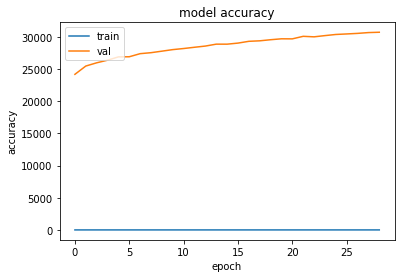

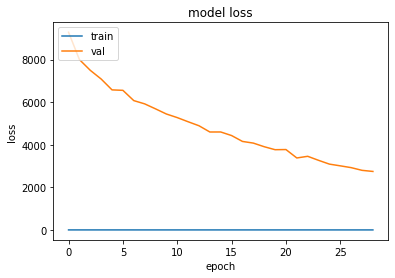

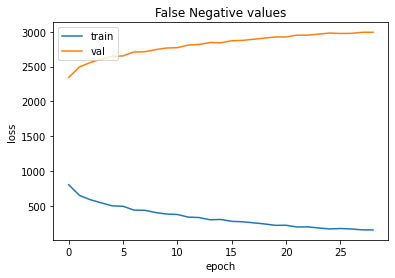

In [ ]:
keys = list(model.history.history.keys())
#accuracy
plt.plot(model.history.history[keys[1]])
plt.plot(model.history.history[keys[4]])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# loss
plt.plot(model.history.history[keys[0]])
plt.plot(model.history.history[keys[3]])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# False Negative
plt.plot(model.history.history[keys[2]])
plt.plot(model.history.history[keys[5]])
plt.title('False Negative values')
plt.ylabel('False Negatives')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
from PIL import Image
from numpy import asarray
def standardize(img,mean):
    std = 55.30462222768374
    img = (img - mean) / std
    return img
target = []
for img in test_df['image_name']:
    r_channel = standardize(asarray(Image.open('../input/melanoma-merged-external-data-512x512-jpeg/512x512-dataset-melanoma/512x512-dataset-melanoma/'+img).resize((224,224)))[:,:,0], mean[0])
    g_channel = standardize(asarray(Image.open('../input/melanoma-merged-external-data-512x512-jpeg/512x512-dataset-melanoma/512x512-dataset-melanoma/'+img).resize((224,224)))[:,:,1], mean[1])
    b_channel = standardize(asarray(Image.open('../input/melanoma-merged-external-data-512x512-jpeg/512x512-dataset-melanoma/512x512-dataset-melanoma/'+img).resize((224,224)))[:,:,2], mean[2])
    prediction = model.predict(np.expand_dims(np.array(np.stack([r_channel, g_channel, b_channel], axis=-1)),0),verbose=0)
    target.append(prediction[0][0])

In [ ]:
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(test_df['target'],target, multi_class="ovr",average='weighted')
auc

0.679959652693745

In [ ]:
test_filenames = os.listdir("../input/melanoma-merged-external-data-512x512-jpeg/512x512-test/512x512-test")
test_dataFrame = pd.DataFrame(test_filenames)
test_dataFrame['image_name'] = pd.DataFrame(test_filenames)

In [ ]:
from PIL import Image
from numpy import asarray
def standardize(img,mean):
    std = 55.30462222768374
    img = (img - mean) / std
    return img
target = []
for img in test_filenames:
    r_channel = standardize(asarray(Image.open('../input/melanoma-merged-external-data-512x512-jpeg/512x512-test/512x512-test/'+img).resize((224,224)))[:,:,0], mean[0])
    g_channel = standardize(asarray(Image.open('../input/melanoma-merged-external-data-512x512-jpeg/512x512-test/512x512-test/'+img).resize((224,224)))[:,:,1], mean[1])
    b_channel = standardize(asarray(Image.open('../input/melanoma-merged-external-data-512x512-jpeg/512x512-test/512x512-test/'+img).resize((224,224)))[:,:,2], mean[2])
    prediction = model.predict(np.expand_dims(np.array(np.stack([r_channel, g_channel, b_channel], axis=-1)),0),verbose=0)
    target.append(prediction[0][0])

In [ ]:
test_df = pd.DataFrame({
    'image_name': test_filenames
})
test_df['target'] = pd.DataFrame(target)
submission_df = test_df.copy()
submission_df['image_name'] = submission_df["image_name"].str.split('.').str[0]
submission_df.to_csv('sub_D9v14.csv', index=False)

submission_df.head()

,image_name,target
0,ISIC_2417927,0.000928
1,ISIC_0546632,0.001095
2,ISIC_2227618,0.000508
3,ISIC_7969975,0.000369
4,ISIC_3356592,0.010799
